In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[4.1065e-03, 2.9699e-01, 3.9767e-03, 1.2424e-08, 6.9493e-01, 4.3107e-09,
          2.7032e-12, 2.1230e-07, 4.7820e-10, 1.0508e-07]]),
 tensor([[0.1316, 0.3099, 0.1308, 0.0104, 0.3674, 0.0084, 0.0019, 0.0183, 0.0054,
          0.0159]]),
 tensor([[0.1475, 0.2264, 0.1471, 0.0414, 0.2465, 0.0372, 0.0178, 0.0550, 0.0299,
          0.0513]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

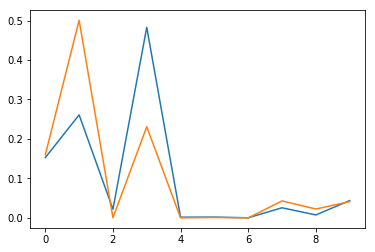

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:       
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        else:              alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad():
            alpha /= 10
            alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.n-self.true_mu,
                             f_s=f_s, f_b_nom=f_b_nom[None,:], f_b_up=f_b_up, f_b_dw=f_b_dw)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
        return ikk
        
    def on_forwards_end(self) -> None:
        
    
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [7]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [16]:
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(aug_alpha=True, n_steps=10, l_mods=None),LossTracker(),SaveBest('weights/best_ii1a.h5'),EarlyStopping(10)])

1: Train=610.5406546020508 Valid=439.2115100097656
2: Train=417.31923736572264 Valid=414.28506042480467
3: Train=400.01786071777343 Valid=404.50195556640625
4: Train=391.1596389770508 Valid=396.54339782714845
5: Train=386.3169738769531 Valid=392.6921496582031
6: Train=379.4425216674805 Valid=388.0968536376953
7: Train=374.25273681640624 Valid=383.0263067626953
8: Train=370.49690307617186 Valid=380.55492614746095
9: Train=366.6888720703125 Valid=376.4040515136719
10: Train=363.2357815551758 Valid=373.8103216552734
11: Train=360.3496896362305 Valid=371.5985992431641
12: Train=357.90312622070314 Valid=368.3118688964844
13: Train=355.73495910644533 Valid=364.50755981445315
14: Train=352.1950375366211 Valid=363.0251416015625
15: Train=350.3492657470703 Valid=361.793271484375
16: Train=348.2992416381836 Valid=360.1762268066406
17: Train=346.71570861816406 Valid=358.2257995605469
18: Train=344.12651611328124 Valid=355.96186584472656
19: Train=342.7774481201172 Valid=354.15111755371095
20: Tra

156: Train=297.242177734375 Valid=312.3296923828125
157: Train=298.02683151245117 Valid=311.969697265625
158: Train=296.28266830444335 Valid=312.41701171875
159: Train=296.6880610656738 Valid=312.24017578125
160: Train=297.55387557983397 Valid=311.5764971923828
161: Train=297.628493347168 Valid=311.5263995361328
162: Train=296.79853134155275 Valid=311.8344787597656
163: Train=296.81159576416013 Valid=312.2243933105469
Early stopping
Loading best model with loss 311.40468505859377


In [17]:
model.save('weights/Inferno_Test_interp_bm1a.h5')

In [8]:
model.load('weights/Inferno_Test_interp_bm1a.h5')

# Results

In [9]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0


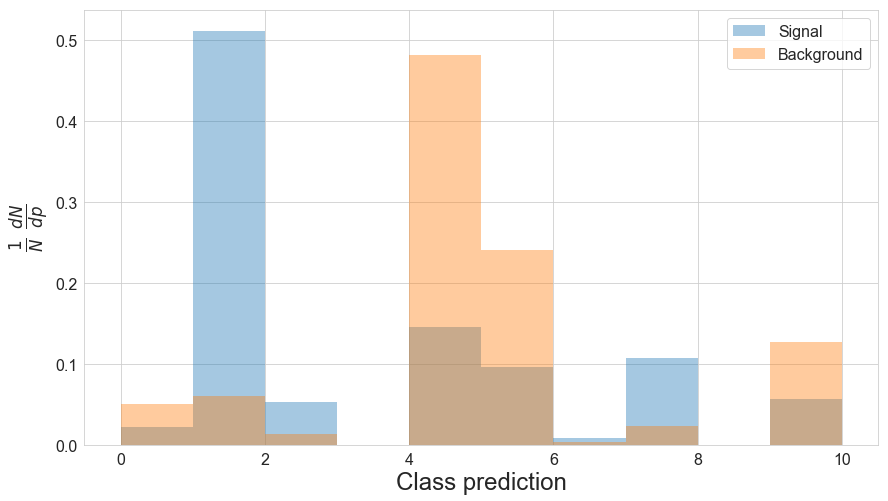

In [25]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [12]:
bin_preds(df)

In [27]:
df.head()

,pred,gen_target,pred_bin
0,5,1.0,5
1,1,1.0,1
2,5,1.0,5
3,7,1.0,7
4,7,1.0,7


In [13]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [29]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.))

In [30]:
f_s, f_b

(tensor([2.1614e-02, 5.1153e-01, 5.3050e-02, 2.0000e-13, 1.4563e-01, 9.6172e-02,
         7.9140e-03, 1.0710e-01, 2.0000e-13, 5.6986e-02]),
 tensor([5.0332e-02, 5.9918e-02, 1.3590e-02, 2.0000e-13, 4.8102e-01, 2.4082e-01,
         3.8960e-03, 2.3766e-02, 2.0000e-13, 1.2665e-01]))

In [31]:
asimov = (50*f_s)+(1000*f_b)

In [32]:
asimov, asimov.sum()

(tensor([5.1413e+01, 8.5495e+01, 1.6242e+01, 2.1000e-10, 4.8831e+02, 2.4563e+02,
         4.2917e+00, 2.9121e+01, 2.1000e-10, 1.2950e+02]), tensor(1050.))

In [33]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([25.56588745, 25.43370438, 25.30659866, 25.18508911, 25.0684967 ,
       24.95737457, 24.85087967, 24.74959183, 24.65312195, 24.56178856,
       24.47488403, 24.39309883, 24.31541824, 24.24312592, 24.17455292,
       24.11123848, 24.05203438, 23.99740601, 23.94678879, 23.90063477,
       23.85883141, 23.82121468, 23.78783607, 23.75836945, 23.73303604,
       23.71180344, 23.69428062, 23.68091774, 23.67154694, 23.66593361,
       23.66388321, 23.66595078, 23.67139053, 23.68080902, 23.69358253,
       23.71019173, 23.73003006, 23.75387764, 23.78063774, 23.81125832,
       23.84507561, 23.88277435, 23.92328835, 23.96720314, 24.01428604,
       24.06525421, 24.11876488, 24.17593002, 24.23553085, 24.29876137,
       24.36520767, 24.43473053, 24.50701523, 24.58239365, 24.66070747,
       24.74228859, 24.82627487, 24.91347504, 25.00359344, 25.09641266,
       25.19190598])

In [34]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [35]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

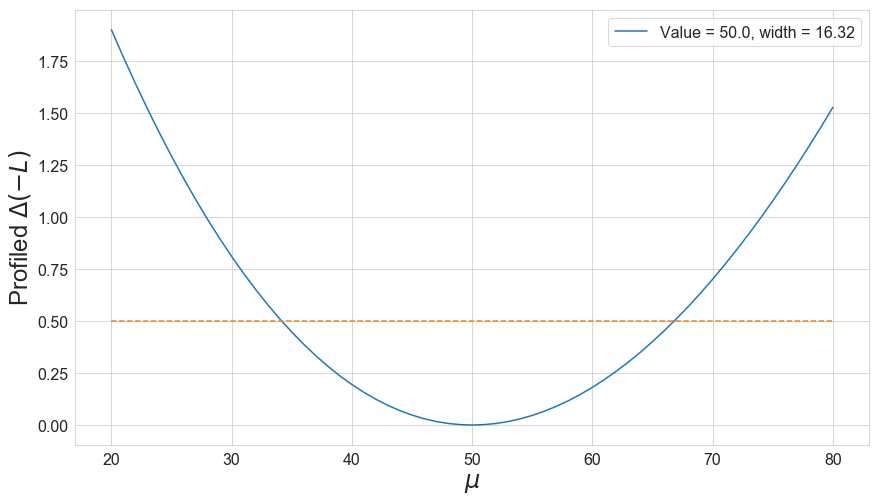

In [36]:
plot_likelihood(y-y.min())

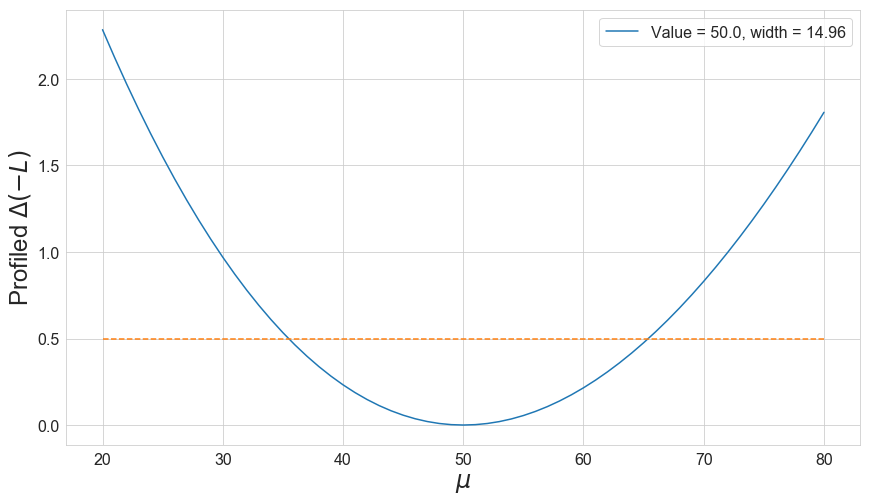

In [37]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [14]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [15]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [40]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,5,1.0,5,5,5,5,5,5,5,5,5,5,5
1,1,1.0,1,1,1,1,1,1,1,1,1,1,1
2,5,1.0,5,5,5,5,5,5,5,5,5,5,5
3,7,1.0,7,7,7,7,7,7,7,7,7,7,7
4,7,1.0,7,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.0,0,0,0,0,0,9,9,0,0,9,9
999996,1,0.0,1,1,1,1,1,7,7,1,1,1,1
999997,5,0.0,5,5,5,5,5,5,5,5,5,5,5
999998,5,0.0,5,5,5,5,5,5,5,5,5,5,5


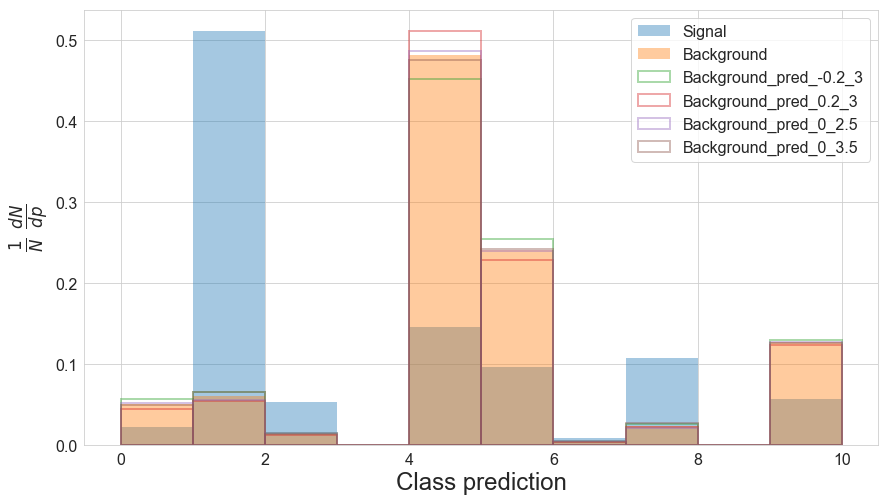

In [41]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([5.8050e-02, 6.0218e-02, 1.5128e-02, 2.0000e-13, 4.5694e-01, 2.5280e-01,
        4.7440e-03, 2.2500e-02, 2.0000e-13, 1.2961e-01])
tensor([5.6654e-02, 6.5354e-02, 1.4430e-02, 2.0000e-13, 4.5118e-01, 2.5389e-01,
        4.2740e-03, 2.5144e-02, 2.0000e-13, 1.2908e-01])
tensor([5.5382e-02, 7.0856e-02, 1.3934e-02, 2.0000e-13, 4.4508e-01, 2.5470e-01,
        3.9500e-03, 2.7790e-02, 2.0000e-13, 1.2831e-01])
tensor([5.1728e-02, 5.4782e-02, 1.4288e-02, 2.0000e-13, 4.8679e-01, 2.3973e-01,
        4.3660e-03, 2.1122e-02, 2.0000e-13, 1.2719e-01])
tensor([5.0332e-02, 5.9918e-02, 1.3590e-02, 2.0000e-13, 4.8102e-01, 2.4082e-01,
        3.8960e-03, 2.3766e-02, 2.0000e-13, 1.2665e-01])
tensor([4.9060e-02, 6.5420e-02, 1.3094e-02, 2.0000e-13, 4.7493e-01, 2.4163e-01,
        3.5720e-03, 2.6412e-02, 2.0000e-13, 1.2588e-01])
tensor([4.5802e-02, 4.9376e-02, 1.3336e-02, 2.0000e-13, 5.1645e-01, 2.2716e-01,
        4.4000e-03, 1.9534e-02, 2.0000e-13, 1.2394e-01])
tensor([4.4406e-02, 5.4512e-02, 1.2638e-0

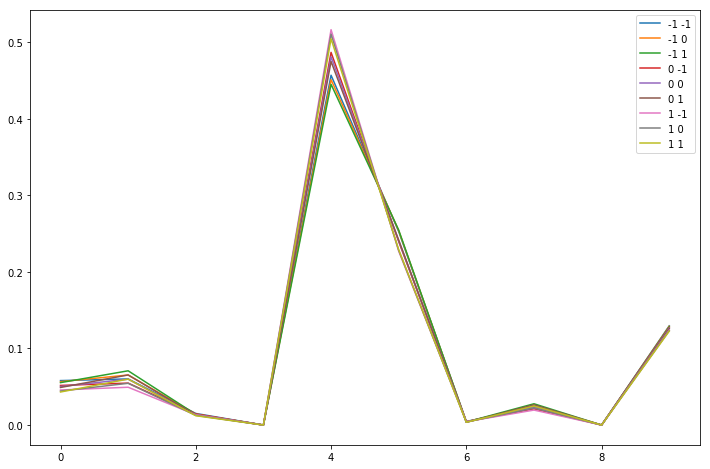

In [42]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [16]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [44]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [45]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [47]:
nll = to_np(nll)

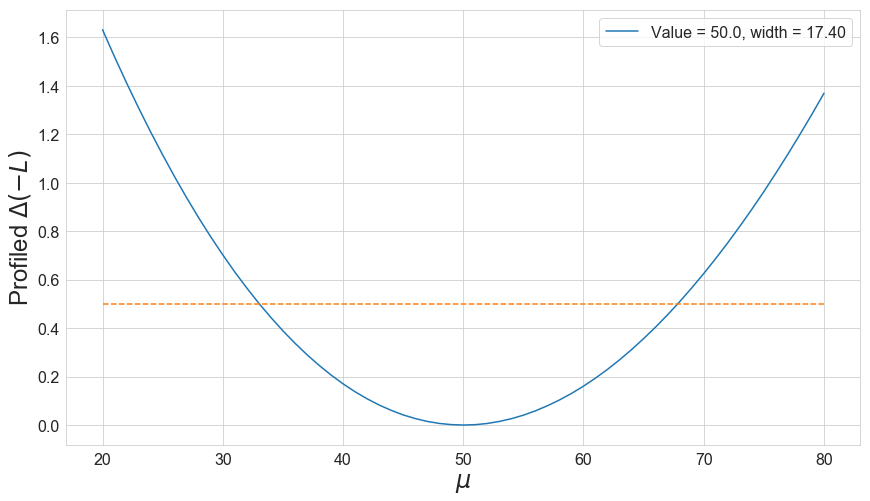

In [48]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [49]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [50]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.5360])
Linear regime: Mu 21.0, alpha tensor([1.4845])
Linear regime: Mu 22.0, alpha tensor([1.4331])
Linear regime: Mu 23.0, alpha tensor([1.3816])
Linear regime: Mu 24.0, alpha tensor([1.3301])
Linear regime: Mu 25.0, alpha tensor([1.2787])
Linear regime: Mu 26.0, alpha tensor([1.2273])
Linear regime: Mu 27.0, alpha tensor([1.1759])
Linear regime: Mu 28.0, alpha tensor([1.1245])
Linear regime: Mu 29.0, alpha tensor([1.0732])
Linear regime: Mu 30.0, alpha tensor([1.0218])
Linear regime: Mu 73.0, alpha tensor([-1.0872])
Linear regime: Mu 74.0, alpha tensor([-1.1343])
Linear regime: Mu 75.0, alpha tensor([-1.1814])
Linear regime: Mu 76.0, alpha tensor([-1.2285])
Linear regime: Mu 77.0, alpha tensor([-1.2755])
Linear regime: Mu 78.0, alpha tensor([-1.3226])
Linear regime: Mu 79.0, alpha tensor([-1.3696])
Linear regime: Mu 80.0, alpha tensor([-1.4166])


In [51]:
nll = to_np(nll)

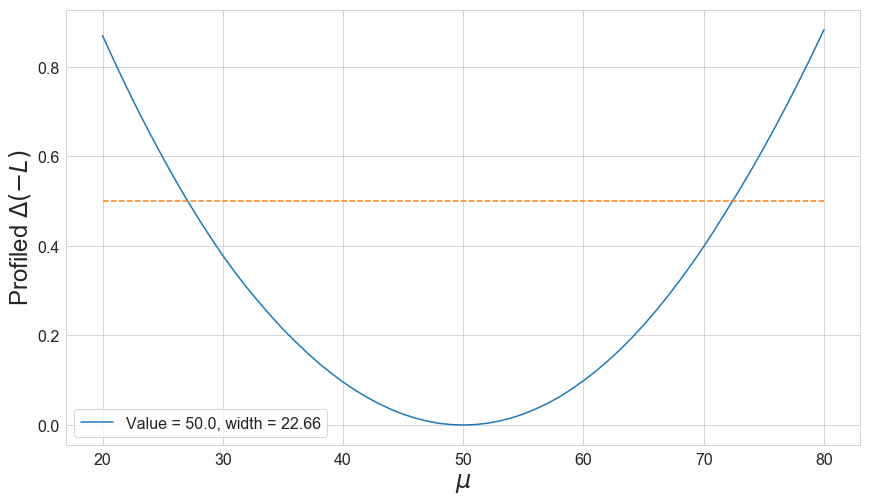

In [52]:
plot_likelihood(nll-nll.min())

## BM 2

In [53]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.0717,  1.4720])
Linear regime: Mu 21.0, alpha tensor([-0.0689,  1.4230])
Linear regime: Mu 22.0, alpha tensor([-0.0660,  1.3740])
Linear regime: Mu 23.0, alpha tensor([-0.0632,  1.3250])
Linear regime: Mu 24.0, alpha tensor([-0.0605,  1.2759])
Linear regime: Mu 25.0, alpha tensor([-0.0577,  1.2269])
Linear regime: Mu 26.0, alpha tensor([-0.0551,  1.1778])
Linear regime: Mu 27.0, alpha tensor([-0.0524,  1.1288])
Linear regime: Mu 28.0, alpha tensor([-0.0498,  1.0797])
Linear regime: Mu 29.0, alpha tensor([-0.0472,  1.0306])
Linear regime: Mu 30.0, alpha tensor([-0.0409,  1.0015])
Linear regime: Mu 74.0, alpha tensor([ 0.0729, -1.0698])
Linear regime: Mu 75.0, alpha tensor([ 0.0755, -1.1146])
Linear regime: Mu 76.0, alpha tensor([ 0.0781, -1.1592])
Linear regime: Mu 77.0, alpha tensor([ 0.0807, -1.2039])
Linear regime: Mu 78.0, alpha tensor([ 0.0832, -1.2486])
Linear regime: Mu 79.0, alpha tensor([ 0.0858, -1.2933])
Linear regime: Mu 80.0, alpha t

In [54]:
nll = to_np(nll)

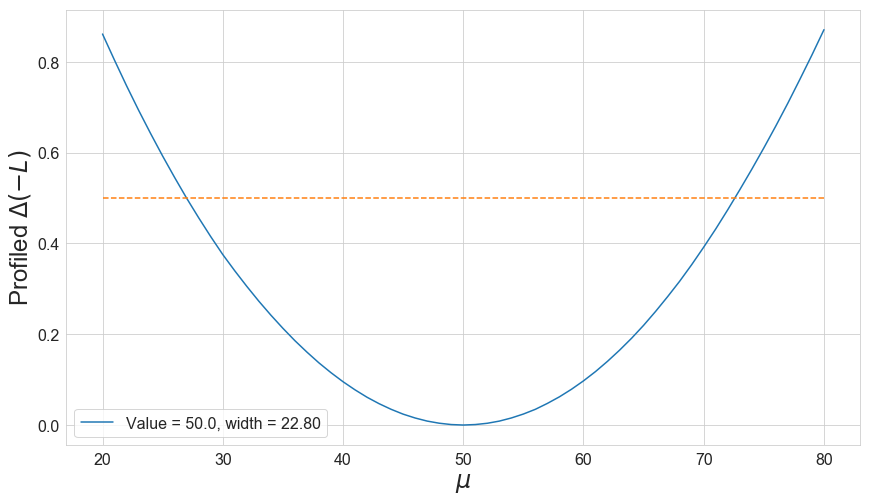

In [55]:
plot_likelihood(nll-nll.min())

## BM 3

In [17]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [18]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.1564,  1.0500])
Linear regime: Mu 21.0, alpha tensor([-0.1508,  1.0141])


In [19]:
nll = to_np(nll)

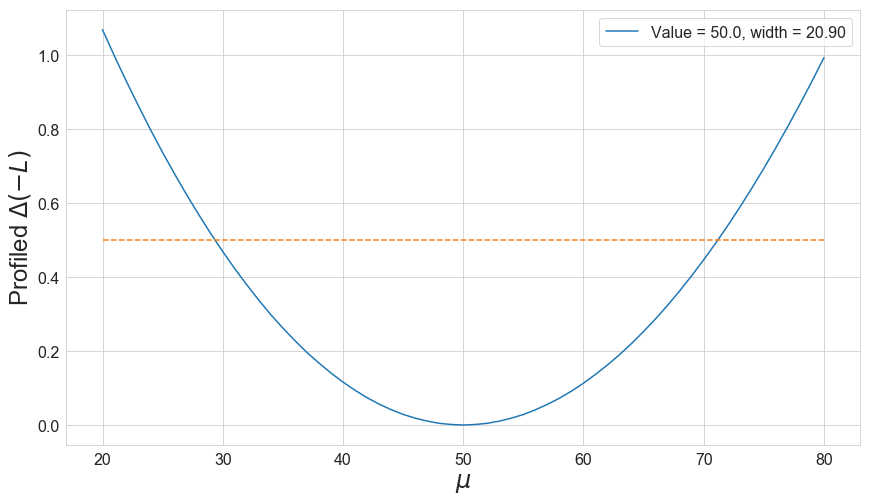

In [20]:
plot_likelihood(nll-nll.min())

## BM 4

In [21]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [22]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.1592,  1.0686, 26.3547])
Linear regime: Mu 21.0, alpha tensor([-0.1537,  1.0328, 25.4382])
Linear regime: Mu 22.0, alpha tensor([-0.1476,  1.0003, 24.5267])
Linear regime: Mu 23.0, alpha tensor([-0.1403,  0.9744, 23.6222])
Linear regime: Mu 24.0, alpha tensor([-0.1350,  0.9379, 22.7127])
Linear regime: Mu 25.0, alpha tensor([-0.1297,  0.9014, 21.8059])
Linear regime: Mu 26.0, alpha tensor([-0.1245,  0.8649, 20.9017])
Linear regime: Mu 27.0, alpha tensor([-0.1192,  0.8284, 20.0002])
Linear regime: Mu 28.0, alpha tensor([-0.1139,  0.7920, 19.1013])
Linear regime: Mu 29.0, alpha tensor([-0.1087,  0.7556, 18.2051])
Linear regime: Mu 30.0, alpha tensor([-0.1034,  0.7192, 17.3115])
Linear regime: Mu 31.0, alpha tensor([-0.0982,  0.6829, 16.4206])
Linear regime: Mu 32.0, alpha tensor([-0.0930,  0.6465, 15.5324])
Linear regime: Mu 33.0, alpha tensor([-0.0877,  0.6103, 14.6468])
Linear regime: Mu 34.0, alpha tensor([-0.0825,  0.5740, 13.7638])
Linear reg

In [23]:
nll = to_np(nll)

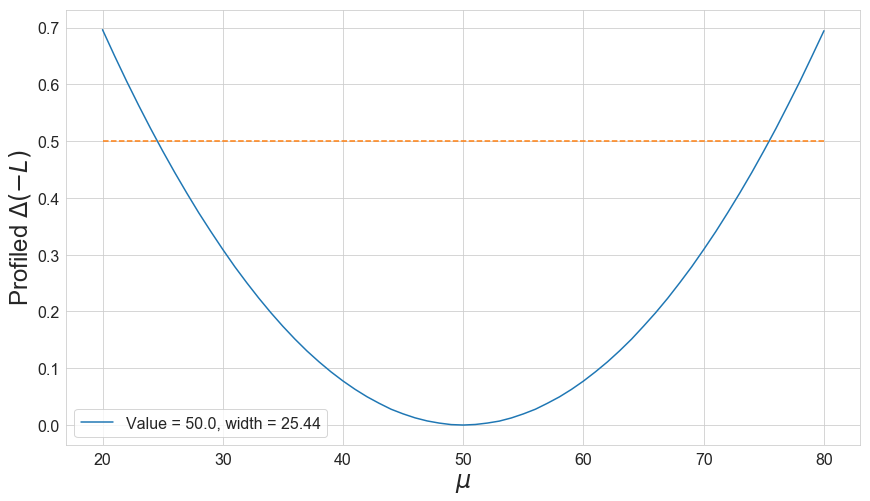

In [24]:
plot_likelihood(nll-nll.min())